# Рекуррентные нейронные сети (РНС)

В сверточных нейронных сетях используется пространственная геометрия данных. Так, операции свертки и пулинга применяются вдоль временной оси для звуковых данных, в двух пространственных измерениях для изображений и в трех измерениях (высота, ширина и время) для видео.

**Рекуррентные нейронные сети** - класс нейронных сетей, в которых учитывается последовательный характер входных данных. На вход подается текст, речь, временной ряд или еще какие-либо данные, в которых появление элемента в последовательности зависит от предшествующих элементов.

РНС можно представить как граф, состоязий из элементарных ячеек, каждая из которых выполгняет одну и ту же опеарцию для каждого элемента последовательности. РНС обладает большой гибкостью и применяется для решения многих задач:
* распознавание речи;
* языковое моделирование
* машинный перевод
* анализ эмоциональной окраски
* теггирование изображений
* и т.д.

РНС можно адаптировать к различным типам задач, изменяя конфигурацию ячеек в графе. 

## Простые ячейки РНС
Традиционно, в нейросетях на основе многослойных перцептронов предполагается, что все входны незаивисимы. В последовательных данных это предположение нарушается. 
Пример: 
* Текст - первое слово предложения влияет и на второе;
* Речь - не расслышав слово можно догадаться какое было слово, исходя из слов который произнес собеседник ранее.
* Временные ряды - цены на акции и прогнозы погоды также характерна зависимость от прошлых данных;

В ячейках РНС эта зависимсть представляется с помозью скрытого состояния (или памяти), в которой хранится сводка прошлой информации. Значение скрытого состояния в любой момент времени - функция значения на предыдущем шаге и значения данных на текущем шаге: 

$$ h_t = \phi(h_{t-1}, x_t)$$

* $h_t, h_{t-1}$ - значения скрытого состояния на шаге $t$ и $t-1$ соответственно,
* $x_t$ - входное значение в момент времени $t$.

Ячейку РНС можно представить графически. В момент $t$ ячейка получает а входе значение $x_t$ и выводит значение $y_t$. Часть $y_t$ (скрытое состояние $h_t$) подается обратно на вход ячейки для использования на сл. шаге $t+1$. Если параметры традиционной нейронной сети хранятся в матрице весов, то параметры РНС задаются тремя матрицами весов $U,V$ и $W$, соответствующими входу, выходу и скрытому состоянию.
![](./img/rnn-pic1.png)
Еще один взгляд на РНС - *развертка*. Это означает, что мы рисуем сеть на протяжении всей последоватевательности. На рисунке изображена РНС с 3 слоями, пригодная для обработки последовательностей с тремя элементами. Заметим, что матрицы весов $U,V,W$ разделяются **между всеми шагами, поскольку на каждом шаге к разным данным применяются одни и те же операции**. Благодаря использвоанию одних и тех же весов на всех временных шагах удается существенно снизить количество обучаемых параметров РНС.

Вычислния выполняемые РНС можно также описать в виде уравнений. Внутреннее состояние РНС в момент времени $t$ определяется значением вектора $h_t$, равного результату применения нелинейности *tanh* к сумме произведения матрицы весов $W$ на скрытое состояние $h_{t-1}$ в момент $t-1$ и произведения матрицы весов $U$ на входное значение $x_t$ в момент $t$. Выбор нелинейности *tanh*, а не какой-то лругой, связан с тем, что её вторая производная очень медленно убывает, приближаясь к нулю, поэтому градиенты остаются в линейной части функции активации, что помогает справится с проблемой **исчезающего градиента**.

Выходной вектор $y_t$ в момент времени $t$ равен результату применения функции *softmax* к произведению матрицы весов $V$ на скрытое состояние $h_t$ и представляет набор вероятностей выхода:
$$ h_t = tanh(Wh_{t-1}+Ux_{t})$$
$$ y_t = softmax(Vh_t)$$

Keras предоставляет слой рекуррентной нейронной сети SimpleRNN, включающий всю описанную логику, и эффективные варианты LSTM и GRU. 

## Простая РНС с применением Keras - порождение текста

РНС активно используется в NLP для решения различных задач. Одна из которых **построения языковых моделей**,. Такая модель позволяет предсказать вероятность появления слова в тексте при условии известных предыдущих слов. Языковые модели важны для таких высокоуровневых прилоежнией, как машинные перевод, исправление правописания и т.д.

Побочным эффектим умения предсказать сл. слово по известным предыдущим является порождающая модель, которая генерирует текст путем переборки слов из выходного распределения. В случае языкового моделирования входом обычно является последовательность слов, а вызолом последовательность предсказанных слов. В роли робучающих данных выступает меющийся непомеченный текст, и метка $y_t$ в момент времени $t$ становится входом $x_{t+1}$ в момент времени $t+1$.

Первым примером исползования Keras для построения РНС будет языковая модель обученная предсказывать следующий символ по 10 рпредыдущим на тексте "Алисы в стране чудес".

Мы остановились на модели предсказания символа, потому что у нее меньше словарь и обучение происходит быстрее. Но та же идея применима к предсказанию слов, нужно только символы заменить словами. Обученная модель будет использована для порождения нового текста в том же стиле.

Сначала импортируем модели:

In [44]:
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

Входной текст "Алисы в Стране чудес" (на англ. языке) берем с сайта проекта Гутенберг по адресу http://www.gutenberg.org/files/11/11-0.txt

Файл содержит символы конца строки и символы не в кодировке ASCII, поэтому произведем предварительную обработку и запишем результат в переменную text:

In [47]:
INPUT_FILE = "./data/11-0.txt"

# extract the input as a stream of characters
print("Extracting text from input...")
fin = open(INPUT_FILE, 'r', encoding='utf-8')
lines = []
for line in fin:
    line = line.strip().lower()
    if len(line) == 0:
        continue
    lines.append(line)
fin.close()
text = " ".join(lines)

Extracting text from input...


Поскольку РНС будет предсказывать символы, то и словарь состоит из множества символов, встречающихся в тексте. Таковых у нас 47. Мы будем иметь дело не с самими символами, а с их индексами, а с индексами, поэтому в сл. фрагменте создаются таблицы соответствия:

In [48]:
# creating lookup tables
# Here chars is the number of features in our character "vocabulary"
chars = set([c for c in text])
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [49]:
char2index

{' ': 32,
 '!': 14,
 '(': 21,
 ')': 15,
 '*': 16,
 ',': 9,
 '-': 25,
 '.': 23,
 '0': 43,
 '3': 46,
 ':': 13,
 ';': 12,
 '?': 29,
 '[': 22,
 ']': 44,
 '_': 7,
 'a': 4,
 'b': 11,
 'c': 27,
 'd': 24,
 'e': 33,
 'f': 0,
 'g': 45,
 'h': 28,
 'i': 35,
 'j': 2,
 'k': 30,
 'l': 39,
 'm': 5,
 'n': 3,
 'o': 8,
 'p': 42,
 'q': 1,
 'r': 41,
 's': 34,
 't': 36,
 'u': 37,
 'v': 6,
 'w': 18,
 'x': 19,
 'y': 20,
 'z': 38,
 '‘': 10,
 '’': 40,
 '“': 26,
 '”': 31,
 '\ufeff': 17}

Следующий шаг - создание входных строк и меток. Для этого проходим по тексту с шагом STEP сиволов (в нашем солуча 1) и выделяем отрезки длиной SEQLEN (в нашем случае 10). Следующий после отрезка символ будет меткой:


In [50]:
# create inputs and labels from the text. We do this by stepping
# through the text ${step} character at a time, and extracting a 
# sequence of size ${seqlen} and the next output char. For example,
# assuming an input text "The sky was falling", we would get the 
# following sequence of input_chars and label_chars (first 5 only)
#   The sky wa -> s
#   he sky was ->  
#   e sky was  -> f
#    sky was f -> a
#   sky was fa -> l
print("Creating input and label text...")
SEQLEN = 10
STEP = 1

input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i:i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


Creating input and label text...


Этот код строит из текста последовательность входных строк и меток:
   
* The sky wa -> s
* he sky was ->  
* e sky was  -> f
*  sky was f -> a
* sky was fa -> l
   
Следующий шаг - векторизация входных строк и меток. На вход РНС подаются построенные выше входные строки. В каждой из них SEQLEN символов, а поскольку размер словаря составляет nb_chars, то каждый входной символ представляется унитарным вектором длины nb_chars. Следовательно, каждый входной элемент представляет собой тензор формы SEQLEN x nb_chars. Выходная метка - это единственный символ , поэтому по аналогии с представлением входных символов она представляется унитарным вектором длины nb_chars.


In [51]:
# vectorize the input and label chars
# Each row of the input is represented by seqlen characters, each 
# represented as a 1-hot encoding of size len(char). There are 
# len(input_chars) such rows, so shape(X) is (len(input_chars),
# seqlen, nb_chars).
# Each row of output is a single character, also represented as a
# dense encoding of size len(char). Hence shape(y) is (len(input_chars),
# nb_chars).
print("Vectorizing input and label text...")
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1

Vectorizing input and label text...


Будем строить модель. Размерность выхода РНС пусть равна будет 128. Это гиперпараметр, определяемый в ходе элементов. В общем случае, если выбрать слишком маленькое значение, то емкость модели будет недостаточна для порождения хороших текстов, и мы увидим длинные серии повторяющихся символов или повторябщиеся группы слов. Если значение слишком велико, то у модели будет слишком много параметров, так что для её обучения потребуется гораздо больше данных. Мы хотим получать на выходе один символ, а не последовательность, поэтому задаем параметр return_sequence=False. Входные данные РНС имеют форму матрицы SEQLEN x nb_chars. Кроме того, задается параметр unroll=True, потому что при этом повышается качество работы базовой библиотеки TensorFlow.

РНС соединяется с плотным (полносвязным) слоем. В плотном слое nb_char нейронов, которые выдают оценки появления каждого символа из словаря. Функция активации в этом случае является softmax которая нормирует оценки, преобразуя их в вероятности. Символ с наибольшей вероятностью возвращается в качестве предсказания. При компиляыии модели задается категориальная перекрестная энтропия в качестве функции потерь (она хорошо подходит для категориального выхода) и оптимизатор RMSProp:


In [52]:
# Build the model. We use a single RNN with a fully connected layer
# to compute the most likely predicted output char
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=False,
                    input_shape=(SEQLEN, nb_chars),
                    unroll=True))
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

Подход к обучению немного отличается от того, что видели прежде. Мы обучали модель в течении фиксированного числа периодов, а затем оценивали её на зарезервированных для этой цели тестовых данных.  Поскольку в данном случае у нас нет помеченных данных, то мы выполняем один период (NUM_EPOCHS_PER_ITERATONS = 1), а затем тестируем модель. Так происходит на протяжении 25 итераций (NUM_ITERATIONS=25). Следовательно, по существу выполяняется NUM_ITERATIONS периодов обучения и тестируем модель после каждого периода.

Тестирование производится так: модель порождает символ по заданныи входным данным, затем первый символ входной строки отбрасывается, в конец дописывается предсказанный на предыдущем прогоне символ и у модели запрашивается сл. предсказание. Так повторяется 100 раз (NUM_PREDS_PER_EPOCH=100), после чего получившаяся строка печатается. Эта строка и является индикатором качества модели:

In [53]:
# We train the model in batches and test output generated at each step
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)
    
    # testing model
    # randomly choose a row from input_chars, then use it to 
    # generate text from model for next 100 chars
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]
    print("Generating from seed: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        pred = model.predict(Xtest, verbose=0)[0]
        ypred = index2char[np.argmax(pred)]
        print(ypred, end="")
        # move forward with test_chars + ypred
        test_chars = test_chars[1:] + ypred
    print()

Iteration #: 0
Epoch 1/1
142635/142635 [==============================] - 29s - loss: 2.3514    
Generating from seed: ver with d
ver with dout the the the the the the the the the the the the the the the the the the the the the the the the 
Iteration #: 1
Epoch 1/1
142635/142635 [==============================] - 26s - loss: 2.0291    
Generating from seed:  interest 
 interest the care the charded the charded the charded the charded the charded the charded the charded the cha
Iteration #: 2
Epoch 1/1
142635/142635 [==============================] - 26s - loss: 1.9241    
Generating from seed: ou know.’ 
ou know.’ ‘i don’t and and all at in a could be and at in a don’t and and all at in a could be and at in a don
Iteration #: 3
Epoch 1/1
142635/142635 [==============================] - 26s - loss: 1.8466    
Generating from seed:  ‘he won’t
 ‘he won’t the mouse for the the said the mock turtle the mouther all the the moust as it little the mouther a
Iteration #: 4
Epoch 1/1
142635/1426

Вначале модель предсказывает вздор, но к концу 25-го периода она пишет почти без ошибок, хотя со связностью мыслей пока дело обстоит неважно. Удивительно что модель обучилась выводить символы и не имеет ни малейшего представления о словах, как будто они взяты из оригинального текста.

Порождение следующего символа или слова - не единственное на что способна такая модель. Подобные модели успешно применялись для предсказания цен на акции (Financial Market Time Series Prediction with Recurrent Nural Networks) и для генераци классической музыки (DeepBach: A steerable Model for Bach Chorales Generation).

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## Топологии РНС

API многослойного перцептрона и сверточной сети ограничены. Обе архитектуры принимают на входе и порождают на выходе тензоры фиксированного размера, а для преобразования входа в выход выполняют фиксированное число шагов, определяемое числом слоев сети. У РНС такого ограничения нет - входом, выходом или тем и другим могут быть поселдовательности. Это означает, что для решения конкретных задач РНС можно конфигурировать разными способами.

Как мы знаем, РНС комбинирует входной вектор с предыдущим вектором состояния для получения новго вектора состояния. Это можно рассматривать как аналог выполнения программы с некоторыми входными данными и внутренними переменными. Следовательно, РНС можно считать способом описания компьютерных программ и доказано, что РНС являются полными по Тьюрингу исполнителям ("On the computational Power of Neural Nets") в том смысле, что при задании надлежащих весов они могут моделировать произвольные программы.

Умение работать с последовательноcтями открывает возможность для различных топологий, некоторые из которых мы рассмотрим.

В базовой структуре все входные последовательности имеют одинаковую длину, а выход порождается на каждом временном шаге. Пример уже видели ранее.

![](./img/rnn-pic2.png)


Другой пример РНС сети типа **многие-ко-многим** - сеть машинного перевода (b), являющаяся представителем общего семейства сетей последовательность-в-последовательность (seq-2-seq) (O. Vinyals "Grammar as a Foreign Language"). Они принимают на вход последовательность и порождают другую последовательность.

В случае машинного перевода входом может быть, например, последовательность английскиз слов, а выходом - переведенное предложение на испанском языке.

Такой же тип модели используется для PoS-тэггинга. От предыдущей топологии эта отличается тем, что в некоторые моменты времени может отсутствовать вход, а в некоторые - выход.

Еще один вариант топологии - сеть типа **один-ко-многим** на рисунке (c), римером которой может служить сеть для подписывания изображений (A. Karphathy, F. Li "DeepVisual-Semantic Alignment for Generating Image Description"), где вход - изображение, а выход - последовательность слов.

Пример сети типа **многие-ко-многим** - сеть анализа эмоциональной окраски предложений, где вход - последовательность слов, а выход - индикатор положительной или отрицательной окраски (R. Socher "Recursive Deep Models for Semantic Compositionality over a Sentiment Treebank"). 


## Проблема исчезающего и взрывного градиента

Как в традиционных нейронных сетях, обучение РНС включает обратное распространение ошибки. Различие в том, что поскольку на всех шагах используются одинаковые параметры, то и градиент в кажом выходе зависит не только от текущего временного шага, но и от предыдущих.

Этот процесс называется **обратным распространением во времени (backpropagation through time, BPTT)**.


![](./img/rnn-pic3.png)

Рассмотрим небольшую трехслойную сеть. В процессе прямого распространения (сплошные линии) сеть порождает предсказания, которые сравниваются с метками для вычисления потери $L_t$ на каждом временном шаге. В процессе обратного распространения (пунктирные линии) на каждом временном шаге вычисляются градиенты функции потерь по параметрам $U,V,W$ и сумма градиентов применяется 
для обновления параметров. 

В следующем уравнении показан градиент функции потерь по матрице $W$ в которой закодированы веса для долгосрочных зависимостей. Мы акцентируем внимание на этой части обновления, потому что именно она - причина **проблемы исчезающего и взрывного градиента**. Два других градиента функици потерь по матрицам $U$ и $V$ также суммируются по всем временным шагам:

$$\frac{\partial L}{\partial W} = \sum_t \frac{\partial L_t}{\partial W}$$

Посмотрим что происходит с градиентом функции потреь на последнем временном шаге ($t=3$). Этот градиент можно разложить в произведение трех подградиентов, применив правило дифференцирования сложной функции. Градиент скрытого состояния $h_2$ по $W$ можно затем представить в виде суммы градиентов каждого скрытого состояния по предыдущему. Наконец, градиент скрытого состояния по предыдущему можно разложить в произведение градиентов текущего скрытого состояния по предыдущему:

$$\frac{\partial L_3}{\partial W} = \frac{\partial L_3}{\partial y_3}\frac{\partial y_3}{\partial h_2}\frac{\partial h_2}{\partial W} = \sum_{t=0}^{2} \frac{\partial L_3}{\partial y_3}\frac{\partial y_3}{\partial h_2}\frac{\partial h_2}{\partial h_t}\frac{\partial h_t}{\partial W} = \sum_{t=0}^{2}\frac{\partial L_3}{\partial y_3}\frac{\partial y_3}{\partial h_2}(\prod_{j=t+1}^{2}\frac{\partial h_j}{\partial h_{j-1}})\frac{\partial h_t}{\partial W} $$

Аналогично вычисляются градиенты функции потерь $L_1$ и $L_2$ (на шагах 1 и 2) по $W$, после чего их сумма используется для оьновления градиента по $W$.

Последнего выражения градиента в формуле выше достаточно чтобы понять откуда возникает проблема исчезающего и взрывного градиента в РНС. Рассмотрим случай, когда отдельные градиенты скрытого состояния по рпедыдущему меньше 1. При обратном распространении ошибки через несколько временных шагов произведение градиентов становится все меньше и меньше, что и ведет к проблеме исчезающего градиента. С другой стороны, если градиенты больше 1, то произведения растут - вот вам и проблема взрывного градиента.

Из-за эффекта исчезающего градиента получается, что градиенты на отдаленных шагах не дают никакого вклада в процесс обучения, так что РНС не может учесть долговременные зависимости. Эта проблема может возникнуть и в традиционной нейронной сети, но в большинстве случае в РНС она проявляется более рельефно, потому что в РНС больше слоев (временных шагов), через которые проходит обратное распространение. 

Взрывные градиенты обнаруживаются проще, поскольку когда градиент становится слишком большим он превращается в NaN и процесс обучения аварийно завершается. Рост градиента можно контролировать, например, обрезая их по достижении заданного орога (R. Pascanu, T. Mikolov, Y. Benguo "On the Difficulty of Training Recurrent Neural Networks").

Существует несколько подходов к смягчению проблемы исчезающих градиентов, в частности, хорошая инициализация матрицы $W$, использование функции активации ReLU вместо tanh и предобучение слоев без учителя, но наиболее популярны архитекуры LSTM и GRU. Они специально проектировались для борьбы с исчезающим градиетом и более эффективно обучаются долговременным зависимостям.

## Долгая краткосрочная память (LSTM)

LSTM - вариант РНС, способный обучаться долгосрочным зависимостям. LSTM сети впервые были предложены Хохрайтером и Шмидхубером, а затем улучшены многими другими исследователями. Они хорошо работают для широкого круга задач и являются самым популярным типом РНС. 

В простой РНС для реализации рекуррентности используется комбинация скрытого состояния на пр. шаге и текущих входных данных в слое с функцией активации. В LSTM-сети рекурреньность реализуется аналогично, но tanh-слоев не один, а четыре, и взаимодействуют они весьма специфичным образом. На рис. показаны преобразования, применяемые к скрытому состоянию на временном шаге $t$:

![](./img/rnn-pic4.png)

Выглядит сложно, рассмотрим схему по шагам.

Горизонтальная линия сверху изображает состояние ячейки $c$, оно представляет внутреннюю память блока. На линии снизу показано скрытое состояние, а вентили $i,f,o,g$ - механизмы, посредством которых LSTM-сеть обходит проблему исчезающего градиента. В процессе обучения LSTM находит параметры этих вентелей.

Чтобы лучше понять как эти вентили модулируют скрытое состояние LSTM-сети, рассмотрим формулы вычисления скрытого состояния $h_t$ в момент $t$ по состоянию $h_{t-1}$ на предыдущем шаге:
$$i=\sigma(W_i h_{t-1} + U_{i}x_{t})$$
$$f = \sigma(W_f h_{t-1} + U_{f}x_{t})$$
$$ o = \sigma(W_{o}h_{t-1}+U_{o}x_{t})$$
$$g = tanh(W_{g}h_{t-1} + U_{g}x_{t})$$
$$c_t = (c_{t-1} \otimes f) \oplus ( g \otimes i)$$
$$ h_t = tanh(c_t) \otimes o $$

Здесь $i,f,o$ - входной вентиль, вентиль забывания и выходной вентиль. Все они вычисляются по одним и тем же формулам, но с разными матрицами параметров. Сигмоидная функция модулирует выход вентилей, приводя их к диапазону $[0;1]$, поэтому порождаемый выходной вектор можно умножить поэлементно на другой вектор, чтобы определить какая часть второго вектора может пройти через первый.

Вентиль забывания определяет, какую часть пред. состояния $h_{t-1}$ желательно пропустить дальше. Входной вентиль определяет, какую часть вновь вычисленного состояния для текущего входа $x_t$ пропустить, а выходной вентиль - какую часть внутреннего состояния передать сл. слою. Внутреннее скрытое состояние $g$ вычисляется на основе текущего входа $x_t$ и предыдущего скрытого состояния $h_{t-1}$. Отметим, что выражение для $g$ совпадает с аналогичным выражением для ячейки простой РНС, но в данном случае мы модулируем выход, смешивая его с выходом входного вентиля $i$.

Зная $i,f,g,o$ мы можем вычислить состояние ячейки $c_t$ в момент времени $t$ в терминах произведения $c_{t-1}$ на вентиль забывания и произведения $g$ на входной вентиль $i$. Это и есть способ комбинирования предыдущего содержимого памяти с новым входом. Если вентиль забывания установлен в 0, то старое запомненное состояние полностью игнорируется, а если установить в 0 ходной вентиль, то игнорируется новое вычисленное состояние.

Наконец, скрытое состояние $h_t$ в момент $t$ вычисляется путем умножения памяти $c_t$ на значение выходного вентиля. 

Важно понимать, что LSTM можно всегда подставить вместо ячейки типа SimpleRNN и единственная разница состоит в том, что LSTM устойчива к проблеме исчезающего градиента. Заменив ячейку РНС на LSTM, мы можем не волноваться ни о каких побочных эффектах.


## Пример LSTM - анализ эмоциональной окраски

Keras предоставляет слой LSTM, которым мы воспользуемся чтобы построить и обучить сеть РНС типа многие-к-одному. Сеть будет пренимать предложение (последовательность слов) и выдавать индикатор эмоциональной окраски. Обучающий набор состоит примерно из 7000 коротких предложений, предлагавшихся на конкурсе Kaggle UMICH SI650 по классификации эмоциональной окраски.

Начинаем с импорта:

In [25]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

Займемся исследовательским анализом данных. Нужно знать сколько уникальных слов в корпусе текстов и сколько слов в каждом предложении:

In [38]:
DATA_DIR = "./data"



# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

In [29]:
## Get some information about our corpus
print(maxlen)            # 42
print(len(word_freqs))   

42
2328


Зная кол-во уникальных слов len(word_freqs), задаем фиксированный размер словаря, все остальные слова считаем несловарными и заменяем их фиктивным словом UNK (unknown). На этапе предсказания это позволит нам обрабатывать ранее не встречавшиеся слова как несловарные.

Зная число слов в предложении (maxlen), мы можем задать фиксированную длину предложения и более короткие предложения дополнять нулями, а длинные обрезать. Хотя РНС способна обрабатывать последовательности перемненой длины, достигается эо обычно дополнением и обрезанием, как описано выше, или группировкой входных данных в пакеты, содержащие последовательности одинаковой длины. Будем использовать первый подход.

Исходя из вычисленных показателей, задаем VOCABULAAZY SIZE равным 2328 + 2: 2328 слов словар плюс фиктивные слова UNK и PAD (использьзуется для дополнения предложений до фикированного числа слов, в нашем случае MAX_SENTENCE_LENGTH = 42).


In [31]:
MAX_FEATURES = 2340
MAX_SENTENCE_LENGTH = 42

Понадобится пара таблиц соответствия. ВХодные данные для РНС - индексы слов, причем лова упорядочены по убыванию частоты встречаемости в обучающем наборе. Таблицы соответствия позволят находить индекс по слову и слово по индексу (включая фиктивные слова PAD и UNK):

In [32]:
# 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 featurs to accound for PAD
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in 
                enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

Затем мы преобразуем входые предложения в последовательности индексов слов, дополняя их до MAX_SENTENCE_LENGTH слов. Поскольку в нашем случае результат - бинарная величина (положительная или отрицательная тональность), обрабатывать метки не нужно:

In [35]:
# convert sentences to sequences
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open(os.path.join(DATA_DIR, "umich-sentiment-train.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

In [36]:
# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

Разбиваем набор данных на обучающий и тестовый в пропорции 80:20:

In [37]:
# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, 
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 42) (1418, 42) (5668,) (1418,)


Ниже представлена структура нашей РНС:
![](./img/rnn-pic5.png)

Входные данные - последовательность индексов слов. Длина последовательности равна MAX_SENTENCE_LENGTH. Первому измерению тензора присваивается значение None, показывающее что размер пакета (число записей загружаемых в сеть за один раз), в момент определения сети неизвестен, он будет задан на этапе выполнения с помощью параметра batch_size.

Таким образомэ, в предположении, что размер пакета пока неизвестен, входной тензор имеет форму (None, MAX_SENTENCE_LENGTH, 1). Такие тензоры подаются на вход слоя погружения размра EMBEDDING_SIZE, веса которого инициализированы небольшими случайными значениями и подлежат обучению. Этот слой преобразует входной тензор к форме (None, MAX_SENTENCE_LENGTH, EMBEDDING_SIZE). Выход слоя погружения задается в LSTM с длиной поселдовательности MAX_SENTENCE_LENGTH и размером выходного слоя HIDDEN)LAYER_SIZE. На выходе LSTM получается тензор формы (None, HIDDEN_LAYER_SIZE, MAX_SENTENCE_LENGTH). По умолчанию LSTM выводит единственный тензор формы (None, HIDDEN_LAYER_SIZE) в качестве результирующей последовательности (return_sequence=False). Он подается на вход плотного слоя с размеровм выхода 1 и сигмоидной функции активации, который выводит 0 (отрицательная окраска), или 1 (положительная окраска).

При компиляции модели указывается бинарная перекрестная энтропия как функция потерь, и Adam - универсаьный оптимизатор.

Гиперпараметры EMBEDDING_SIZE, HIDDEN_LAYER_SIZE, BATCH_SIZE и NUM_EPOCHS выбраны по результатам экспериментов:

In [40]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Build model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, 
                    input_length=MAX_SENTENCE_LENGTH))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 24s - loss: 0.2323 - acc: 0.8968 - val_loss: 0.0509 - val_acc: 0.9817
Epoch 2/10
5668/5668 [==============================] - 19s - loss: 0.0303 - acc: 0.9899 - val_loss: 0.0392 - val_acc: 0.98241s - loss: 0.
Epoch 3/10
5668/5668 [==============================] - 19s - loss: 0.0078 - acc: 0.9984 - val_loss: 0.0427 - val_acc: 0.9838.99
Epoch 4/10
5668/5668 [==============================] - 19s - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0437 - val_acc: 0.9901
Epoch 5/10
5668/5668 [==============================] - 18s - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9880
Epoch 6/10
5668/5668 [==============================] - 18s - loss: 0.0072 - acc: 0.9981 - val_loss: 0.0429 - val_acc: 0.9880
Epoch 7/10
5668/5668 [==============================] - 18s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0514 - val_acc: 0.9901
Epoch 8/10
5668/5668 [==============================] 

На результатах выполнения программы видно как убивает потеря и растет верность.

Построим графики зависимости потери и верности в зависимости от времени:


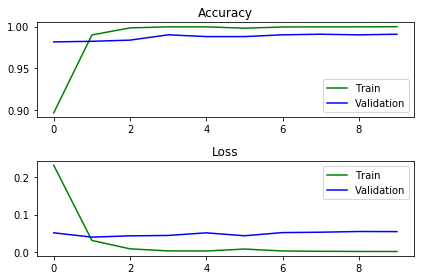

In [41]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


Модель оценивается на полном тестовом наборе. Выбираем также несколько сл. предложений из тестового набора и печатаем предсказание РНС, метку и само предложение:

In [43]:
# evaluate
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,42)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1376/1418 [============================>.] - ETA: 0sTest score: 0.054, accuracy: 0.991
1	1	i love kirsten / leah / kate escapades and mission impossible tom as well ...
1	1	brokeback mountain was beautiful ...
1	1	da vinci code was an awesome movie ...
1	1	because i would like to make friends who like the same things i like , and i really like harry potter , so i thought that joining a community like this would be a good start .
1	1	i love harry potter..


#### Recurrent dropout
Можно заметить, что появился новый для нас параметр recurrent_dropout.

Взглянем на документацию Keras: 
**dropout: Float between 0 and 1. *Fraction of the units to drop for the linear transformation of the inputs.*

**recurrent_dropout**: Float between 0 and 1. *Fraction of the units to drop for the linear transformation of the recurrent state.*

Обычный **dropout** применяется на входах и/или выходах, которые представляются вертикальными стрелками от $x_$ к $h_t$. Если добавить его в качестве аргументка к слою, он будет "маской" для входов, Вы также можете добавить слой Dropout после рекуррентного слоя, для наложения "маски" на выход. **Recurrent dropout** использует связи между рекуррентными уровнями (они соответствуют горизонтальным стрелкам на рисунке).

![](https://i.stack.imgur.com/fWDtw.png)
Слева - обычный dropout на входе и выходе. Справа обычный dropout + рекуррентный dropout


## Вентильный рекуррентный блок (GRU)

Вентильный рекуррентный блок (gated rucurrent unit, GRU) - это вариант LSTM, впервые предложенный К. Чо (Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation). Он также обладает устойчивостью к проблеме исчезающего градиента, но его внутренняя структура проще, а потому и обучается он быстрее, т.е. для обновления скрытого состояния нужно меньше вычислений. На сл. рисунке показаны вентили в ячейке GRU:
![](./img/rnn-pic6.png)

Вместо трех вентелей в ячейке LSTM - входного, забывания и выходного, в ячейке GRU всего два вентиля: обновления $z$ и сброса $r$. Вентиль обновления определяет, какую часть предыдущего запомненного значения сохранить, а вентиль сброса - как смешивать новых вход с предыдущей памятью. Не существует никакого постоянного состояния ячейки, отличного от скрытого состояния, как в LSTM. Механизм GRU описывается сл. формулами:
$$z = \sigma(W_zh_{t-1} + U_z x_t)$$
$$r = \sigma (W_r h_{t-1} + U_rx_t)$$
$$c = tanh(W_c (h_{t-1}\otimes r) + U_c x_t $$
$$ h_t = (z \otimes c ) \oplus ((1-z)\otimes h_{t-1})$$

Согласно эмпирическим оценкам качество GRU и LSTM сранимо, и нельзя дать априорную рекомендацю, какую модель выбрать для конкретной задачи. GRU быстрее обучаются и требуют меньше данных для достижения генерализации, но в ситуациях, когда обучающих данных достаточно, большая выразительность LSTM может давать лучшие результаты.

Как и LSTM, GRU можно подставить вместо ячейки типа SimpleRNN. 

### Пример GRU - частеречная разметка

В этом суть лабораторной работы #1 :)


Класс моделей последовательность в последовательность обладает мощными выразительными возможностями. Его каноническое приложение - **машинный перевод**, но есть и много других.
* Распознавание именованных сущностей (Hammerton : "Named Entity Recognition with LSTM");
* Грамматический разбор предложения (Vanyals "Grannar as a Foreign Language");
* Подписывание изображений ( Karhathy, Li "Deep Visual-Semantic Alignment for Generating Image Descriptions);


## Двунаправленные РНС
Выход РНС в момент времени $t$ зависитот выходов на всех предшествующих временных шагах. Но вполне может случиться, в частности для приложений NLP, когда атрибуты слова или фразы, которые мы пытаемся предсказать будут зависеть от контекста определяемого всем предложением, а не только предшествующими словами. Двунаправленные РНС помогают построить архитектуру сети, которая придает одинаковую важность началу и концу предложения, и позволяют увеличить объем данных, доступных для обучения.

Двунаправленная РНС - это две РНС, собранных вместе, которые читают входные данные в разных направлениях. В нашем примере одна РНС будет читать слова от начала предложения к концу, а другая - от коца к началу. Выход на каждом временном шаге будет зависеть от скрытого состояния обеих РНС.

Keras поддерживает двунаправленные РНС с помощью обертки: Bidirectional.
Использование такое же:


In [ ]:
from keras.layers.wrappers import TimeDistributed, Bidirectional

model = Sequential()
model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, dropout_W=0.2, dropout_U=0.2)))
model.add(RepeatVector(MAX_SEQLEN))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(t_vocabsize)))
model.add(Activation("softmax"))

## РНС с запоминанием состояния
РНС может сохранять состояние при переходе от одного пакета к другому во время обучения.Иначе говоря, скрытое состояние, вычисленное для одного пакета обучающих данных используется в качестве начального скрытого состоояния для сл. пакета. Но этот режим необходимо задавать явно, поскольку в Keras РНС по умолчанию не запоминает состояние и сбрасывает его после каждого пакета. Запоминание состояния позволяет РНС строить свое внутреннее состояние на протяжении обработки всей последовательности обучающих данных и даже использовать его на этапе предсказания.

К достоинствам РНС с запоминанием состояния сл. отнести меньший размер сети и(или) сокращение времени обучения, а к недостаткам - то что теперь мы несем ответственность за выбор такого размера пакета, который отражает периодичность данных, и за сброс состояния после каждого периода. Кроме того, данные не следует перетасовывать в процессе обучения, потому что для сетей с запоминанием состояния порядо крпедъявления данных **существенен*.

### Пример LSTM с запоминанием состояния - предсказание потребления электричества

Предскажем потребление электричества с помощью LSTM сети с запоминанием и без запоминания состояния и сравним результаты. В моделях с запминанием состояния внутреннее состояние, вычисленное для элемента $i$ в предыдущем пакете будет использоваться в качетсве начального состояния элемента $i$ в сл. пакете.

Для обучения будем использовать набор данных из репозитория UCI: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

содержит информацию о потреблении электричества 370 потребителями с интервалом 15 минут за период с 2011 по 2014 гг. Для примера выберем потребителя с номеров 250.

Большинство задач можно решить с помощью РНС без запоминания состояни, поэтому прибегая к РНС с запоминанием состояния, нужно понимать, зачем вы это делаете. Как правило, такая необходимость появяется когда в данных имеется некоторая **периодичность**. Для потребления электричества характерна периодичность - потребление выше днем и ниже ночью.

Выделим данные для потребителя 250 , нарисуем график за 10 дней и сохраним данные в бинарном формате NumPy.


0 lines read
5000 lines read
10000 lines read
15000 lines read
20000 lines read
25000 lines read
30000 lines read
35000 lines read
40000 lines read
45000 lines read
50000 lines read
55000 lines read
60000 lines read
65000 lines read
70000 lines read
75000 lines read
80000 lines read
85000 lines read
90000 lines read
95000 lines read
100000 lines read
105000 lines read
110000 lines read
115000 lines read
120000 lines read
125000 lines read
130000 lines read
135000 lines read
140000 lines read


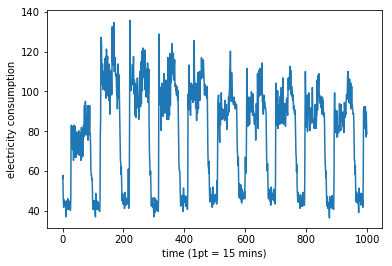

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

DATA_DIR = "./data"

fld = open(os.path.join(DATA_DIR, "LD2011_2014.txt"), "r", encoding='utf-8')
data = []
line_num = 0
#cid = np.random.randint(0, 370, 1)
cid = 250
for line in fld:
    if line.startswith("\"\";"):
        continue
    if line_num % 5000 == 0:
        print("{:d} lines read".format(line_num))
    cols = [float(re.sub(",", ".", x)) for x in 
            line.strip().split(";")[1:]]
    data.append(cols[cid])
    line_num += 1
fld.close()

NUM_ENTRIES = 1000
plt.plot(range(NUM_ENTRIES), data[0:NUM_ENTRIES])
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15 mins)")
plt.show()

np.save(os.path.join(DATA_DIR, "LD_250.npy"), np.array(data))

Имеется отчетливая суточная периодичность, поэтому модель с запоминанием состояния отлично подойдет. Из результатов наблюдения следует что имеет смысл взять BATCH_SIZE = 96 (кол-во 15 минутных отсчетов за 24 часа).
Покажем одновременно код обоих версий: с запоминанием состояния и без.


In [5]:
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import os

Using TensorFlow backend.


In [6]:
STATELESS = False

NUM_TIMESTEPS = 20
HIDDEN_SIZE = 10
BATCH_SIZE = 96  # 24 hours (15 min intervals)
NUM_EPOCHS = 5


Загрузим данные для потребителя 250 в большой массив из сохраненного двоичного файла NumPy и нормируем его по диапазону [0;1]. Изменим форму входных данных на трехмерную.

In [8]:
DATA_DIR = "./data"
data = np.load(os.path.join(DATA_DIR, "LD_250.npy"))

# scale the data to be in the range (0, 1)
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data = scaler.fit_transform(data)

При обработке каждого пакета модель принимает последовательность 15-минутных отсчетов и предсказывает следующий. Длина входной последовательности определяется переменной NUM_TIMESTEPS. По результатам экспериментов выбрано значение TIMESTEPS = 20, т.е. длина входной последовательности = 20, а выходной: 1. На сл. шаге входной массив преобразовывается в тензоры X и Y формы (None, 4) и (None, 1). Наконец, входной тензор X преобразуется в трезмерный в соответствии с требованиями сети.


In [9]:
# transform to 4 inputs -> 1 label format
X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]

# reshape X to three dimensions (samples, timesteps, features)
X = np.expand_dims(X, axis=2)

Разбиваем тензоры X и Y на обучающий и тестовый наборы (соотношение 70:30). Поскольку мы работаем с временными рядами, то просто выбираем точку разделения и разрезаем данные на 2 части, не пользуясь функцией train_test_split, которая дополнительно перетасовывает данные:


In [10]:
# split into training and test sets (add the extra offsets so 
# we can use batch size of 5)
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(98179, 20, 1) (42077, 20, 1) (98179, 1) (42077, 1)


Определим модель без сохранения состояния. Кроме того, задаются значения переменных BATCH_SIZE и NUM_TIMESTEPS. Размер выхода LSTM определяется переменной HIDDEN_SIZE, это еще один гиперпараметр, который обычно выставляется по результатам экспериентов. Мы задали значение 10, ибо цель наша - просто сравнить 2 сети.

In [17]:
# stateless model

model_stateless = Sequential()
model_stateless.add(LSTM(HIDDEN_SIZE, input_shape=(NUM_TIMESTEPS, 1), 
                   return_sequences=False))
model_stateless.add(Dense(1))

Модель с сохранением состояния очень похожа. В конструкторе LSTM нужно задать параметр 
    stateful=True,
а вместо параметра
    input_shape,
в котором подразумевается, что размер пакета определяется на этапе выполнения, задается параметр batchnput_shape, где этот размер указывается явно. Кроме того, размеры обучающего и тестового набора даннх должны быть кратны размеру пакета.

In [18]:
model_stateful = Sequential()
model_stateful.add(LSTM(HIDDEN_SIZE, stateful=True,
                   batch_input_shape=(BATCH_SIZE, NUM_TIMESTEPS, 1), 
                   return_sequences=False))
model_stateful.add(Dense(1))



Код компиляции модели одинаков для обоих РНС. В роли показатели качества выступает MSE, поскольку рассматривается задача регрессии. 

In [19]:
model_stateless.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["mean_squared_error"])
model_stateful.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["mean_squared_error"])

Для обучения модели без состояния достаточно одной строки:

In [20]:
# stateless
model_stateless.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(Xtest, Ytest),
              shuffle=False)

Train on 98112 samples, validate on 42048 samples
Epoch 1/5
98112/98112 [==============================] - 32s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/5
98112/98112 [==============================] - 30s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/5
98112/98112 [==============================] - 30s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/5
98112/98112 [==============================] - 30s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/5
98112/98112 [==============================] - 30s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0044 - val_mean_squared_error: 0.0044


Соответствующий код для модели с сохранением состояния приведен ниже.

Но есть 3 важных момента:
1. Размер пакета **должен отражать периодичность данных**, поскольку РНС с сохранением состояния сопоставляет состояния соответственных элементов соседних пакетов, а это значит, что при правильном размере пакета сеть будет обучаться быстрее. Размеры обучающего и тестового наборов должны быть кратны размеру пакета. Мы обеспечили выполнение этого условия, отбросив последние несколько данных в обеих наборах;

2. В цикле обучаем модель на протяжении заданного числа периодов, при этом состояние сохраняется при переходе от пакета к пакету. Но после каждого периода состояние модели нужно сбросить вручную.

3. Данные необходимо передавать строго последовательно. По умолчанию Keras перетасовывает данные в каждом пакете, а эо наруашет соответствие элементов, необхоидмое для эффективного обучения РНС с сохранением состояния. Чтобы отменить тасование, задается параметр shuffle=False при обращении к model.fit():


In [21]:
    # stateful
    # need to make training and test data to multiple of BATCH_SIZE
    train_size = (Xtrain.shape[0] // BATCH_SIZE) * BATCH_SIZE
    test_size = (Xtest.shape[0] // BATCH_SIZE) * BATCH_SIZE
    Xtrain, Ytrain = Xtrain[0:train_size], Ytrain[0:train_size]
    Xtest, Ytest = Xtest[0:test_size], Ytest[0:test_size]
    print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
    for i in range(NUM_EPOCHS):
        print("Epoch {:d}/{:d}".format(i+1, NUM_EPOCHS))
        model_stateful.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=1,
                  validation_data=(Xtest, Ytest),
                  shuffle=False)
        model_stateful.reset_states()

(98112, 20, 1) (42048, 20, 1) (98112, 1) (42048, 1)
Epoch 1/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 23s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 21s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 21s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 20s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/9811

Наконец, оценим обе модели на тестовых данных:


In [1]:
score, _ = model_stateless.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse = math.sqrt(score)
print("Stateless model:\n'tMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

score, _ = model_stateful.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse = math.sqrt(score)
print("Stateful model:\n'tMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

NameError: name 'model_stateless' is not defined

Как можно заметить, результаты модели с сохранением состояния чуть лучше. Однако нужно помнить, что мы привели данные к диапазону (0;1).